# EEG Classifictaion using LSTM

This used used LSTM model to classify  electroencephalogram (EEG) brain signal and to predict the human emotions 


##  load & read the dataset

In [2]:
# importing and mounting google drive in the notebook
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%matplotlib inline

import warnings
import itertools    
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

sns.set_style('dark')

warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/Datasets/EEG/emotions.csv')
df.head()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB


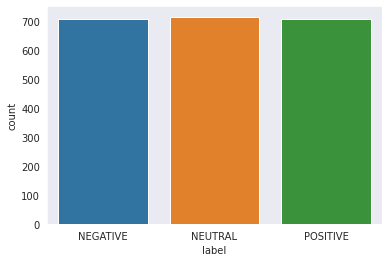

In [6]:
import seaborn as sns
sns.countplot(x='label', data=df)


In [7]:
df.isnull().sum()
#no missing values

# mean_0_a    0
mean_1_a      0
mean_2_a      0
mean_3_a      0
mean_4_a      0
             ..
fft_746_b     0
fft_747_b     0
fft_748_b     0
fft_749_b     0
label         0
Length: 2549, dtype: int64

In [ ]:
encode = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
#new dataset with replaced values
df_encoded = df.replace(encode)

print(df_encoded.head())
print(df_encoded['label'].value_counts())

In [9]:
df_encoded['label'].unique()

array([2, 0, 1])

In [ ]:
df_encoded.head()

In [11]:
x=df_encoded.drop(["label"]  ,axis=1)
x.shape

(2132, 2548)

In [12]:
y = df_encoded.loc[:,'label'].values
y.shape


(2132,)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)
from keras.utils import to_categorical
y = to_categorical(y)
y

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
y

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [15]:
x_train = np.reshape(x_train, (x_train.shape[0],1,x.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0],1,x.shape[1]))


In [16]:
import tensorflow as tf
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()

model = Sequential()
model.add(LSTM(64, input_shape=(1,2548),activation="relu",return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation="sigmoid"))
model.add(Dropout(0.2))
#model.add(LSTM(100,return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(50))
#model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid'))
from keras.optimizers import SGD
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             668928    
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 681,443
Trainable params: 681,443
Non-trainable params: 0
_________________________________________________________________


In [18]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_lstm_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
                                    
model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
lstm_h = model.fit(x_train, y_train,
                   batch_size=32,
                   validation_data=(x_test, y_test),
                   epochs=50,
                   callbacks=[es, mc, lr_schedule])

Epoch 1/50
51/54 [===========================>..] - ETA: 0s - loss: 0.5716 - accuracy: 0.8235
Epoch 1: val_accuracy improved from -inf to 0.92272, saving model to ./best_lstm_model.h5
54/54 [==============================] - 6s 25ms/step - loss: 0.5650 - accuracy: 0.8270 - val_loss: 0.3448 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 2/50
51/54 [===========================>..] - ETA: 0s - loss: 0.2888 - accuracy: 0.9357
Epoch 2: val_accuracy did not improve from 0.92272
54/54 [==============================] - 1s 15ms/step - loss: 0.2920 - accuracy: 0.9326 - val_loss: 0.2708 - val_accuracy: 0.9204 - lr: 9.0484e-04
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9413
Epoch 3: val_accuracy improved from 0.92272 to 0.92740, saving model to ./best_lstm_model.h5
54/54 [==============================] - 1s 17ms/step - loss: 0.2293 - accuracy: 0.9413 - val_loss: 0.2241 - val_accuracy: 0.9274 - lr: 8.1873e-04
Epoch 4/50
54/54 [=============================

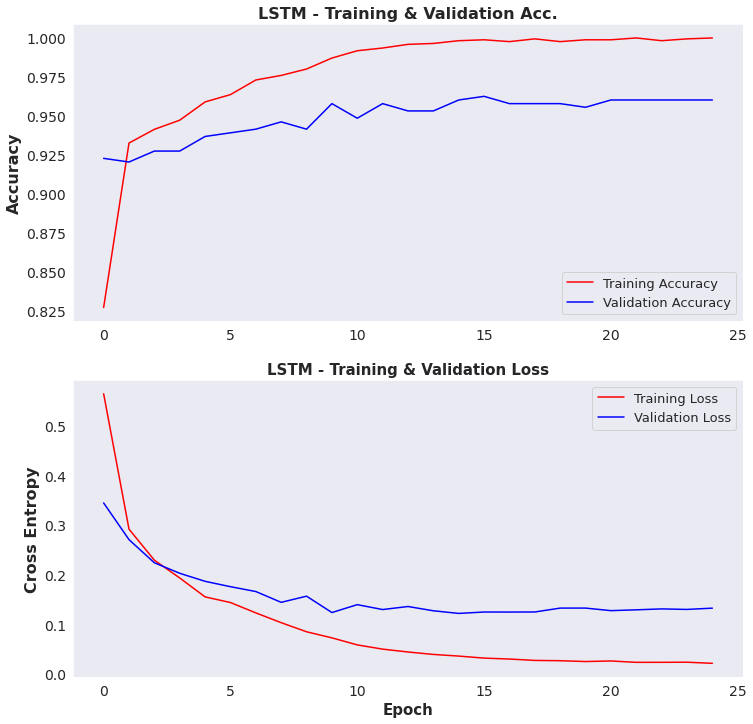

In [19]:
acc = lstm_h.history['accuracy']
val_acc = lstm_h.history['val_accuracy']

loss = lstm_h.history['loss']
val_loss = lstm_h.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [20]:
lstm_best = load_model('./best_lstm_model.h5')
lstm_acc = lstm_best.evaluate(x_test, y_test, verbose=0)[1]
print("Test Acc.: {:.3f}%".format(lstm_acc * 100))

Test Acc.: 96.253%


In [24]:
from sklearn.metrics import accuracy_score
pred = lstm_best.predict(x_test)
predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y_test,axis=1)
print(expected_classes.shape)
print(predict_classes.shape)
correct = accuracy_score(expected_classes,predict_classes)
print(f"Training Accuracy: {correct}")

14/14 [==============================] - 0s 4ms/step
(427,)
(427,)
Training Accuracy: 0.9625292740046838


In [33]:
print(classification_report(expected_classes, predict_classes))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       153
           1       0.98      0.91      0.94       142
           2       0.94      0.99      0.96       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



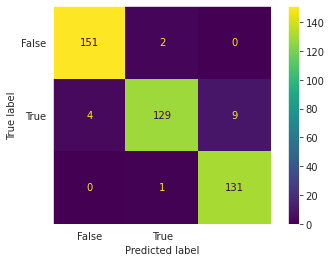

In [27]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(expected_classes, predict_classes)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()